## import resources/root file

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import trange
import uproot as up
import pandas as pd
import seaborn as sns

In [4]:
file = up.open("flatTuple_new_large.root");
#print(file.keys());
data = file["ntuplizer"];
#print(file["ntuplizer"].classes());
tree1data = file["ntuplizer"]["tree;3"]
tree2data = file["ntuplizer"]["tree;4"] # 2 trees: 3 and 4
#print(tree1data.keys())

## get rid of arrays within cells --> all tau candidates from same event included

In [ ]:
# some useful functions
get_all_cell_elements_per_column = lambda df,column_name: df[column_name].apply(pd.Series) \
                                        .join(df["eventID"]) \
                                        .melt(id_vars = ["eventID"], value_name = column_name) \
                                        .drop(["variable"], axis = 1) \
                                        .dropna().sort_values(by=['eventID']).reset_index(drop = True)

def create_new_dataframe(df):
    list_of_columns = df.columns # all features
    df["eventID"] = df.index.values  # eventID
    df_new = pd.DataFrame(data= None, columns= list_of_columns)
    for i,column in enumerate(list_of_columns):
        array = get_all_cell_elements_per_column(df,column)[column].values  # this takes <2 seconds
        l = len(array)
        if i == 0:
            df_new[column] = array # this sets up the size of the dataframe; 
            L = len(array)
            continue
        if l < L: # sth wrong if the feature lengths are not the same 
            df_new = df_new.drop(columns=[column])
            continue
        df_new[column] = array
    df_new["eventID"] =  get_all_cell_elements_per_column(df,column)["eventID"].values
    return df_new

In [ ]:
BsTauTau1_tau_df1 = tree1data.pandas.df(["BsTauTau_tau*"], flatten = False) 
Tau_df1 = create_new_dataframe(BsTauTau1_tau_df1)
data1 = Tau_df1[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
        'BsTauTau_tau_pi1_dnn', 'BsTauTau_tau_pi2_dnn',
       'BsTauTau_tau_pi3_dnn', 'BsTauTau_tau_pi1_pt', 'BsTauTau_tau_pi1_eta',
       'BsTauTau_tau_pi1_phi', 'BsTauTau_tau_pi2_pt',
       'BsTauTau_tau_pi2_eta', 'BsTauTau_tau_pi2_phi', 
       'BsTauTau_tau_pi3_pt', 'BsTauTau_tau_pi3_eta', 'BsTauTau_tau_pi3_phi',
       'eventID','BsTauTau_tau_isRight', 'BsTauTau_tau_isRight1',
       'BsTauTau_tau_isRight2', 'BsTauTau_tau_isRight3', 'BsTauTau_tau_dr1',
       'BsTauTau_tau_dr2', 'BsTauTau_tau_dr3', 'BsTauTau_tau_ptres1',
       'BsTauTau_tau_ptres2', 'BsTauTau_tau_ptres3']]

In [ ]:
BsTauTau2_tau_df2 = tree2data.pandas.df(["BsTauTau_tau*"], flatten = False) 
Tau_df2 = create_new_dataframe(BsTauTau2_tau_df2)
data2 = Tau_df2[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
        'BsTauTau_tau_pi1_dnn', 'BsTauTau_tau_pi2_dnn',
       'BsTauTau_tau_pi3_dnn', 'BsTauTau_tau_pi1_pt', 'BsTauTau_tau_pi1_eta',
       'BsTauTau_tau_pi1_phi', 'BsTauTau_tau_pi2_pt',
       'BsTauTau_tau_pi2_eta', 'BsTauTau_tau_pi2_phi', 
       'BsTauTau_tau_pi3_pt', 'BsTauTau_tau_pi3_eta', 'BsTauTau_tau_pi3_phi',
       'eventID','BsTauTau_tau_isRight', 'BsTauTau_tau_isRight1',
       'BsTauTau_tau_isRight2', 'BsTauTau_tau_isRight3', 'BsTauTau_tau_dr1',
       'BsTauTau_tau_dr2', 'BsTauTau_tau_dr3', 'BsTauTau_tau_ptres1',
       'BsTauTau_tau_ptres2', 'BsTauTau_tau_ptres3']]

In [ ]:
data = data1.merge(data2).reset_index()

In [ ]:
print(len(data))
print((data.BsTauTau_tau_isRight == True).sum())
# this is interesting
print(((data.BsTauTau_tau_isRight1 == True) & (data.BsTauTau_tau_isRight2 == True) & (data.BsTauTau_tau_isRight3 == True)).sum())

In [ ]:
# mask needs all the flags to be True
mask = ((data.BsTauTau_tau_isRight1 == True) * (data.BsTauTau_tau_isRight2 == True) * (data.BsTauTau_tau_isRight3 == True) * (data.BsTauTau_tau_isRight == True))
data = data[mask].reset_index()
len(data)

In [ ]:
data = data.drop(columns=['BsTauTau_tau_isRight', 'BsTauTau_tau_isRight1','BsTauTau_tau_isRight2', 'BsTauTau_tau_isRight3'])

## add cartesian coordinates

In [ ]:
data.insert(0, "label_tau_px", pd.eval("data.BsTauTau_tau_pt * cos(data.BsTauTau_tau_phi) "))
data.insert(1, "label_tau_py", pd.eval("data.BsTauTau_tau_pt * sin(data.BsTauTau_tau_phi) "))
data.insert(2, "label_tau_pz", pd.eval("data.BsTauTau_tau_pt * sinh(data.BsTauTau_tau_eta) "))
data.insert(3, "label_tau_abs", pd.eval("data.BsTauTau_tau_pt * cosh(data.BsTauTau_tau_eta) "))

data.insert(4,"pi1_px", pd.eval("data.BsTauTau_tau_pi1_pt * cos(data.BsTauTau_tau_pi1_phi) "))
data.insert(5, "pi1_py", pd.eval("data.BsTauTau_tau_pi1_pt * sin(data.BsTauTau_tau_pi1_phi) "))
data.insert(6, "pi1_pz", pd.eval("data.BsTauTau_tau_pi1_pt * sinh(data.BsTauTau_tau_pi1_eta) "))

data.insert(7,"pi2_px", pd.eval("data.BsTauTau_tau_pi2_pt * cos(data.BsTauTau_tau_pi2_phi) "))
data.insert(8, "pi2_py", pd.eval("data.BsTauTau_tau_pi2_pt * sin(data.BsTauTau_tau_pi2_phi) "))
data.insert(9, "pi2_pz", pd.eval("data.BsTauTau_tau_pi2_pt * sinh(data.BsTauTau_tau_pi2_eta) "))

data.insert(10,"pi3_px", pd.eval("data.BsTauTau_tau_pi3_pt * cos(data.BsTauTau_tau_pi3_phi) "))
data.insert(11, "pi3_py", pd.eval("data.BsTauTau_tau_pi3_pt * sin(data.BsTauTau_tau_pi3_phi) "))
data.insert(12, "pi3_pz", pd.eval("data.BsTauTau_tau_pi3_pt * sinh(data.BsTauTau_tau_pi3_eta) "))

In [ ]:
#data.to_csv("signal_taus.csv")

## function to convert from cartesian to eta-phi space

In [ ]:
def to_eta_phi(preds_df):
    # we need atan2 and not arctan
    preds_df.insert(0,"pred_tau_phi", np.arctan2(preds_df.py, preds_df.px))
    preds_df.insert(1, "pred_tau_pt", pd.eval(" preds_df.px/ cos(preds_df.pred_tau_phi) "))
    preds_df.insert(2, "pred_tau_eta", pd.eval(" arcsinh(preds_df.pz/ preds_df.pred_tau_pt) "))
    return preds_df

## histograms

In [5]:
data = pd.read_csv("signal_taus.csv")

Text(0.5, 1.0, 'pi3_phi')

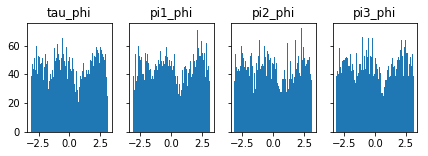

In [6]:
plt.rcParams['figure.figsize'] = [7, 2]
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, sharey= True)
ax1.hist(data.BsTauTau_tau_phi, bins = 100);#, log = True);
ax1.set_title("tau_phi")
ax2.hist(data.BsTauTau_tau_pi1_phi, bins = 100);#, log = True);
ax2.set_title("pi1_phi")
ax3.hist(data.BsTauTau_tau_pi2_phi, bins = 100);#, log = True);
ax3.set_title("pi2_phi")
ax4.hist(data.BsTauTau_tau_pi3_phi, bins = 100);#, log = True);
ax4.set_title("pi3_phi")

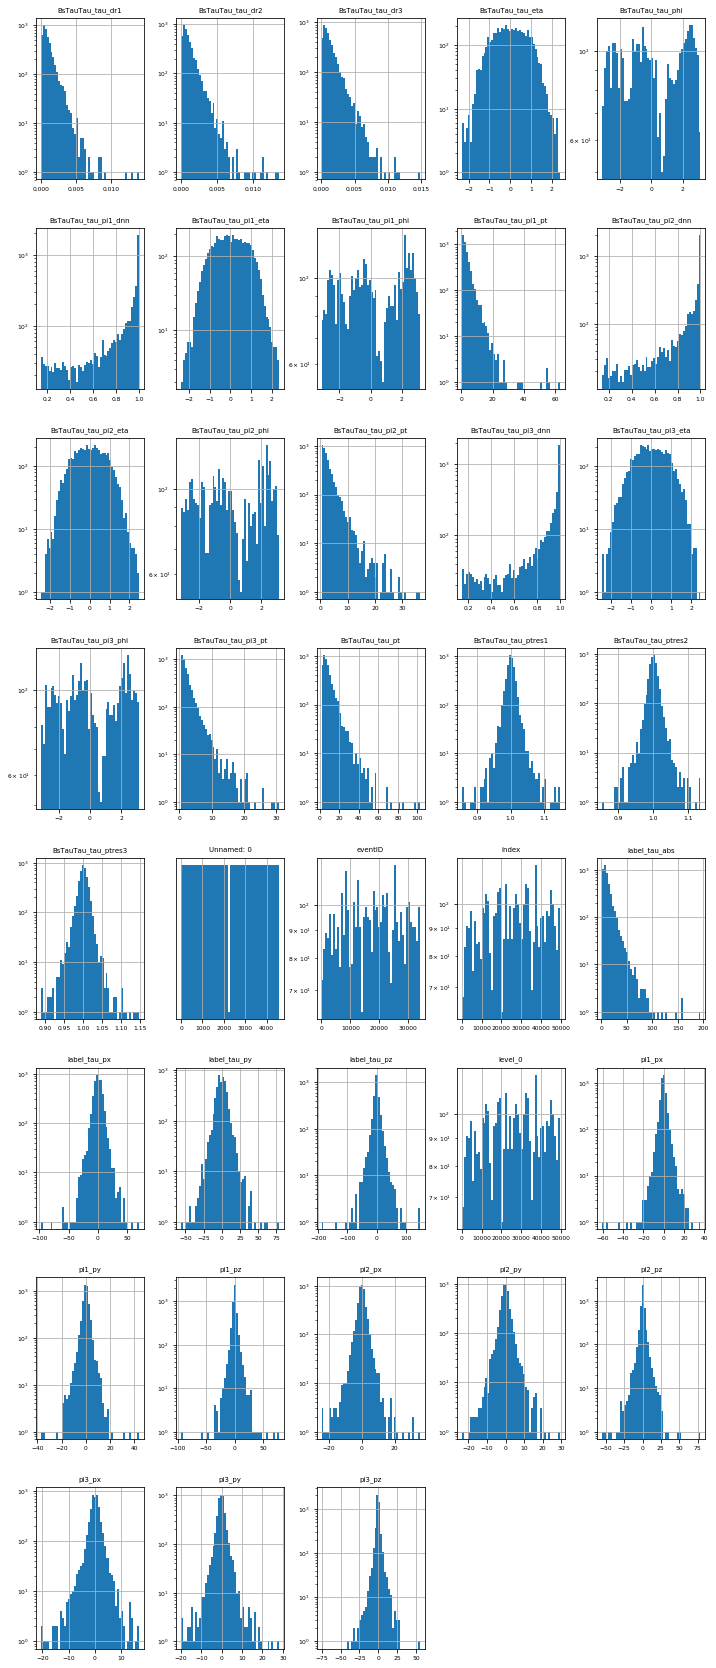

In [7]:
#fig = plt.figure()
plt.rcParams.update({'axes.titlesize': 7})
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
ax = data.hist(bins = 50, figsize = (12,30), layout = (-1,5), log = True, ylabelsize= 6, xlabelsize = 6);
#fig.savefig('data_hists.png')
plt.savefig("h.png")

## scatter pair plots 

In [8]:
data = data.drop(columns=['Unnamed: 0', 'level_0', 'index'])

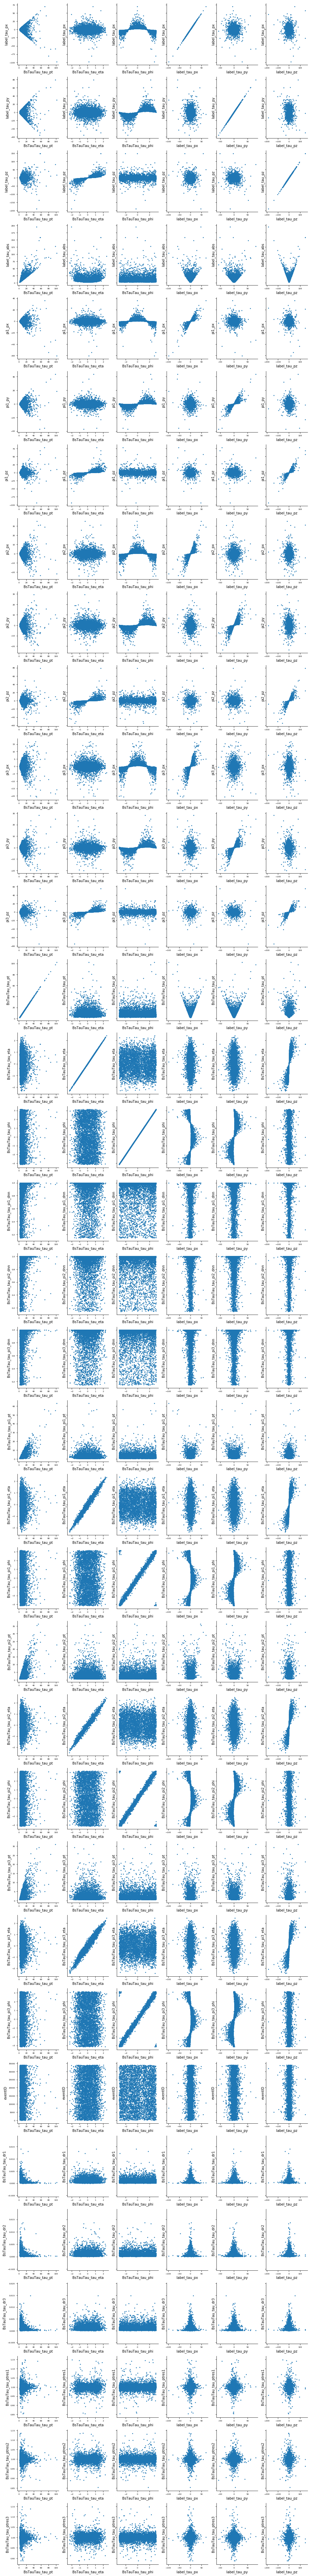

In [9]:
g = sns.PairGrid(data, x_vars= ['BsTauTau_tau_pt',  'BsTauTau_tau_eta', 'BsTauTau_tau_phi','label_tau_px', 
                                'label_tau_py', 'label_tau_pz'], y_vars = data.columns, height=3, aspect=0.7)
g = g.map(plt.scatter, s = 3)
plt.subplots_adjust(hspace=0.2, wspace=0.2)

xlabels,ylabels = [],[]

for ax in g.axes[-1,:]:
    xlabel = ax.xaxis.get_label_text()
    xlabels.append(xlabel)
for ax in g.axes[:,0]:
    ylabel = ax.yaxis.get_label_text()
    ylabels.append(ylabel)

for i in range(len(xlabels)):
    for j in range(len(ylabels)):
        g.axes[j,i].tick_params(axis='x',labelbottom = True)
        g.axes[j,i].xaxis.set_label_text(xlabels[i])
        g.axes[j,i].yaxis.set_label_text(ylabels[j])

plt.savefig("s2.png")

In [10]:
data = pd.read_csv("signal_taus.csv")
len(data.eventID) - len(np.unique(data.eventID.values)) # no taus from same event 

0

In [11]:
# order of pions
data[['BsTauTau_tau_pi1_pt','BsTauTau_tau_pi2_pt','BsTauTau_tau_pi3_pt' ]]

,BsTauTau_tau_pi1_pt,BsTauTau_tau_pi2_pt,BsTauTau_tau_pi3_pt
0,4.937500,2.535156,2.052734
1,1.031250,2.683594,2.992188
2,1.024414,3.255859,2.003906
3,7.417969,6.957031,2.476562
4,6.300781,7.941406,1.027344
...,...,...,...
4594,5.441406,2.236328,1.045898
4595,3.253906,1.673828,3.287109
4596,5.792969,2.490234,11.546875
4597,1.087891,1.990234,0.853516


In [12]:
data.columns

Index(['Unnamed: 0', 'label_tau_px', 'label_tau_py', 'label_tau_pz',
       'label_tau_abs', 'pi1_px', 'pi1_py', 'pi1_pz', 'pi2_px', 'pi2_py',
       'pi2_pz', 'pi3_px', 'pi3_py', 'pi3_pz', 'level_0', 'index',
       'BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
       'BsTauTau_tau_pi1_dnn', 'BsTauTau_tau_pi2_dnn', 'BsTauTau_tau_pi3_dnn',
       'BsTauTau_tau_pi1_pt', 'BsTauTau_tau_pi1_eta', 'BsTauTau_tau_pi1_phi',
       'BsTauTau_tau_pi2_pt', 'BsTauTau_tau_pi2_eta', 'BsTauTau_tau_pi2_phi',
       'BsTauTau_tau_pi3_pt', 'BsTauTau_tau_pi3_eta', 'BsTauTau_tau_pi3_phi',
       'eventID', 'BsTauTau_tau_dr1', 'BsTauTau_tau_dr2', 'BsTauTau_tau_dr3',
       'BsTauTau_tau_ptres1', 'BsTauTau_tau_ptres2', 'BsTauTau_tau_ptres3'],
      dtype='object')